# Proyecto análisis del sueño (Polisomnograma)

## Miguel Hortelano y Francisco Olayo González

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import support_functions_sleep as sp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import cohen_kappa_score, confusion_matrix, plot_roc_curve, RocCurveDisplay, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import seaborn as sns

**Con este proyecto tratamos de clasificar y predecir las distinas etapas del sueño de los pacientes de manera automática, para ello, las fases del sueño se dividirán en 5 etapas:**

0 = W (Despierto)

1 = N1

2 = N2

3 = N3

4 = REM

Hemos decidido utilizar todos los datos de los pacientes, incluyendo los que van marcados por los expertos, ya que había anotaciones de todo tipo y no teníamos información suficiente para establecer un criterio de eliminación de muestras.

Para ello, con esta función extraemos la información cruda mediante el paquete `yasa`, para poder preprocesarla y dividir en ventanas de 30 segundos y, además eliminar las últimas 30 épocas ya que los expertos dicen no son significativas.

Extraemos tanto información de la media de los canales y la desviación estándar como otro tipo de características de cada canal mediante la función `yasa.SleepStaging` que concatenaremos en un dataframe para poder introducir en los modelos.

Para el preprocesado, importación y representación de datos nos hemos ayudado de un archivo externo, creado por nosotros `support_functions_sleep`, que iremos llamando para utilizar ciertas funciones a lo largo del notebook.

Se va a realizar el estudio sobre 10 pacientes, que dividiremos en pacientes de entrenamiento (2-8) y pacientes de test (1 y 10).

In [4]:
Xtr, ytr = sp.data_loader(train_path_list =['../data_sleep/8/8', '../data_sleep/9/9'],
                          metodo = 'a')#'data_sleep/2/2','data_sleep/3/3','data_sleep/4/4','data_sleep/5/5',
                                          #  'data_sleep/6/6', 'data_sleep/7/7',

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

50% del dataset
(76, 970)


C:\Users\morte\anaconda3\lib\site-packages\antropy\entropy.py:1011: RuntimeWarning: invalid value encountered in true_divide
  mob = np.sqrt(dx_var / x_var)
C:\Users\morte\anaconda3\lib\site-packages\antropy\entropy.py:1012: RuntimeWarning: invalid value encountered in true_divide
  com = np.sqrt(ddx_var / dx_var) / mob
C:\Users\morte\anaconda3\lib\site-packages\yasa\spectral.py:322: RuntimeWarning: invalid value encountered in true_divide
  bp /= total_power
C:\Users\morte\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\morte\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
C:\Users\morte\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\mor

Todo correcto
furula
100% del dataset
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

50% del dataset
(76, 939)
Todo correcto
100% del dataset


In [5]:
Xts, yts = sp.data_loader(train_path_list =[
                                            '../data_sleep/10/10'], metodo = 'a')#'data_sleep/1/1',

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

50% del dataset
(76, 766)
Todo correcto
furula
100% del dataset


Eliminamos las variables que incluyen valores perdidos en alguna muestra, tanto en el conjunto de test como en el de train, ya que tenemos suficientes características.

In [6]:
#Buscamos las columnas (variables) que tienen Na y las eliminamos
#al tener muchas variables
nas= np.where(Xtr.isna().any())

nas

(array([1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
        1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194,
        1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1218, 1219, 1220,
        1221, 1222, 1223, 1230, 1231, 1232], dtype=int64),)

In [7]:

Xtr = Xtr.drop(Xtr.columns[nas], axis= 'columns')
Xts = Xts.drop(Xts.columns[nas], axis= 'columns')

## Selección de variables o características.

In [7]:
#Utilizamos un anova para ver las distribuciones de las variables y como clasifican
import scipy.stats as stats

vars_list = []
for var in Xtr.columns:


    a = Xtr[var][[i == 1 for i in ytr]]#separamos la variable en 5 vectores según su clase
    b = Xtr[var][[i == 2 for i in ytr]]
    c = Xtr[var][[i == 3 for i in ytr]]
    d = Xtr[var][[i == 4 for i in ytr]]
    e = Xtr[var][[i == 0 for i in ytr]]
    # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
    fvalue, pvalue = stats.f_oneway(a, b, c, d, e)

    if pvalue < 0.05:#eliminamos aquellas variables que no presenten distribuciones significativas entre las clases
        vars_list.append(var)
print(len(vars_list))


1171


Tras calcular la distribución de las variables con cada clase, mediante un test anova, procedemos a eliminar más variables mediante su importancia en un randomforest ya que seguimos teniendo demasiadas.

Hemos visto que al eliminar mediante el test anova, y posteriormente por importancia de variables, empeora los resultados comparando con solo eliminar por importancia de las variables, por lo que tomamos como solución utilizar solo la importancia de las variables del RandomForest.

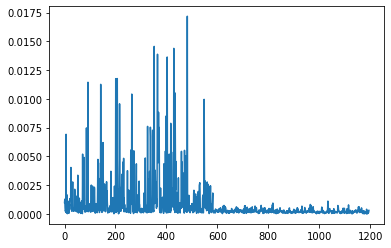

In [8]:
criterion = 'gini'
max_depth = None


rf2 = RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth)
rf2.fit(Xtr, ytr)
plt.plot(rf2.feature_importances_)



In [9]:
#Como tenemos muchisimas caracteristicas, probamos a eliminar mediante un umbral por importancia

features = rf2.feature_importances_
indice= np.where(features< 0.0005)

idx = list(indice[0])

cols = Xtr.columns[idx]

Xtr_reduced = Xtr.drop(labels = cols, axis=1)
Xts_reduced = Xts.drop(labels = cols, axis=1)

## Algoritmos de clasificación

Hemos optado por un enfoque de OnevsRest, ya que hemos pensado era el mejor al tener un problema de clasificación múltiple, y OnevsOne doblaría el tiempo de entrenamiento al enfrentar todas las posibles parejas de clases.

Hemos utilizado varios algoritmos de clasificación como RandomForest, Extratreesclassifier, SVC y comparado resultados mediante el cálculo de el acierto, matrices de confusión, curvas ROC y además indice Cohen-Kappa.
Además de comparar tanto con todas las variables iniciales, como con el conjunto de varaibles reducidas.

### Random forest

Cohen-kappa 0.6319863342764107
0.706266318537859


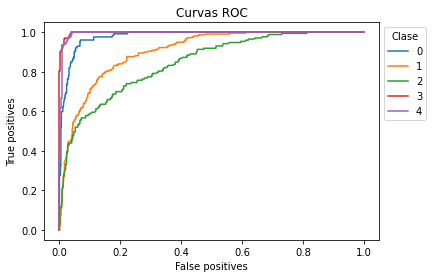

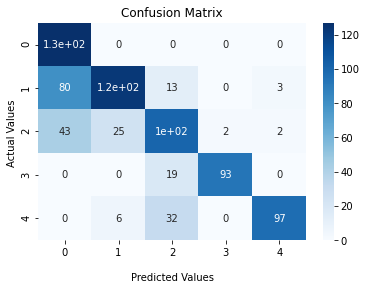

              precision    recall  f1-score   support

           0       1.00      0.51      0.67       250
           1       0.56      0.80      0.66       154
           2       0.58      0.61      0.60       165
           3       0.83      0.98      0.90        95
           4       0.72      0.95      0.82       102

    accuracy                           0.71       766
   macro avg       0.74      0.77      0.73       766
weighted avg       0.76      0.71      0.70       766



In [10]:
## Random forest (ensembles) ##

criterion = 'entropy'
max_depth = None

# Train RF ensemble
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth))
rf.fit(Xtr, ytr)
yb = rf.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts, yts))
Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)
score = rf.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)

print(classification_report(yb, yts))

Cohen-kappa 0.7444050341189392
0.8011834319526627


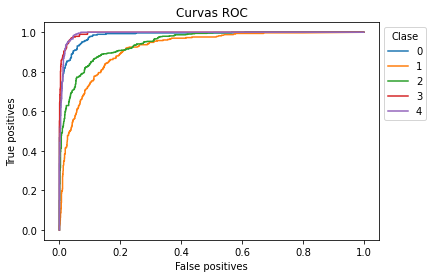

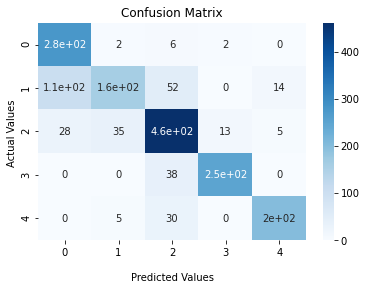

              precision    recall  f1-score   support

           0       0.97      0.68      0.79       413
           1       0.48      0.79      0.60       203
           2       0.85      0.79      0.82       587
           3       0.87      0.94      0.90       267
           4       0.85      0.91      0.88       220

    accuracy                           0.80      1690
   macro avg       0.80      0.82      0.80      1690
weighted avg       0.84      0.80      0.81      1690



In [11]:
## Random forest (ensembles) ## Tamaño reducido de variables

criterion = 'entropy'
max_depth = None

# Train RF ensemble
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth))
rf.fit(Xtr_reduced, ytr)
yb = rf.predict(Xts_reduced)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts_reduced, yts))
Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)
score = rf.predict_proba(Xts_reduced)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)
print(classification_report(yb, yts))

### Extratrees classifier

Cohen-kappa 0.5855914189197824
0.6684073107049608


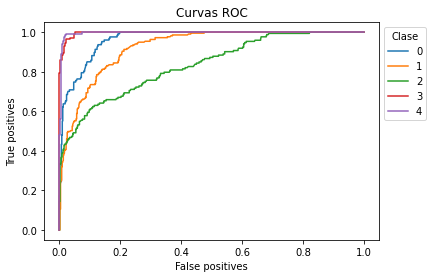

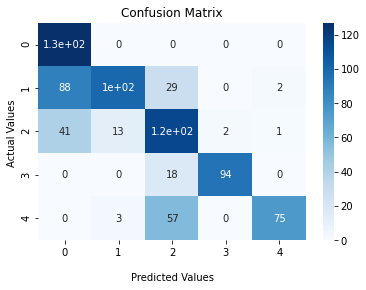

              precision    recall  f1-score   support

           0       1.00      0.50      0.66       256
           1       0.46      0.86      0.60       116
           2       0.67      0.53      0.59       220
           3       0.84      0.98      0.90        96
           4       0.56      0.96      0.70        78

    accuracy                           0.67       766
   macro avg       0.70      0.77      0.69       766
weighted avg       0.76      0.67      0.67       766



In [11]:
## Extratrees classifier (ensembles) ##

criterion = 'entropy'
max_depth = None



# Train RF ensemble
rf = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth))
rf.fit(Xtr, ytr)
yb = rf.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts, yts))
Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)
score = rf.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)
print(classification_report(yb, yts))

Cohen-kappa 0.6355066201495803
0.7088772845953003


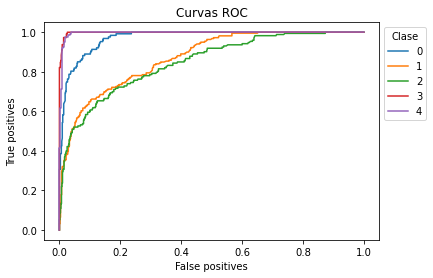

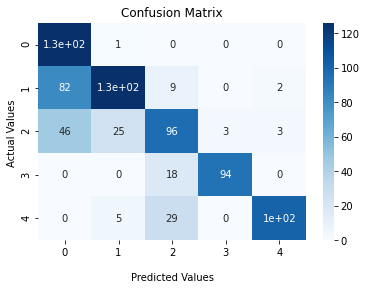

              precision    recall  f1-score   support

           0       0.99      0.50      0.66       254
           1       0.58      0.80      0.67       157
           2       0.55      0.63      0.59       152
           3       0.84      0.97      0.90        97
           4       0.75      0.95      0.84       106

    accuracy                           0.71       766
   macro avg       0.74      0.77      0.73       766
weighted avg       0.77      0.71      0.70       766



In [12]:
## Extratrees classifier (ensembles) ## Tamaño reducido de variables

criterion = 'entropy'
max_depth = None

# Train RF ensemble
rf = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth))
rf.fit(Xtr_reduced, ytr)
yb = rf.predict(Xts_reduced)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts_reduced, yts))
Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)
score = rf.predict_proba(Xts_reduced)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)
print(classification_report(yb, yts))

### SVC

Cohen-kappa 0.7162285687604496
0.778698224852071


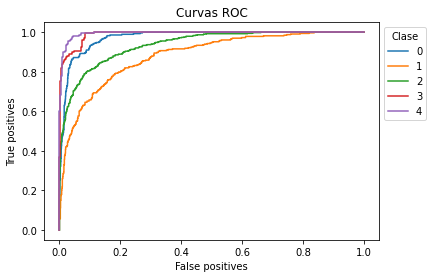

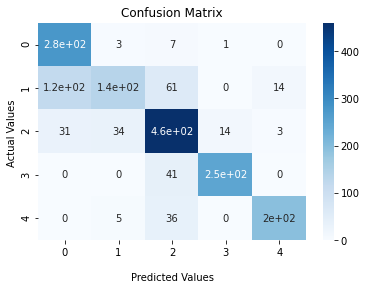

              precision    recall  f1-score   support

           0       0.95      0.59      0.73       463
           1       0.47      0.78      0.58       201
           2       0.82      0.79      0.80       564
           3       0.82      0.96      0.88       246
           4       0.86      0.94      0.90       216

    accuracy                           0.78      1690
   macro avg       0.78      0.81      0.78      1690
weighted avg       0.82      0.78      0.78      1690



In [15]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto',  probability=True))
#svm = OneVsRestClassifier(SVC(gamma = 'auto', probability=True))
svm.fit(Xtr_reduced, ytr)
yb = svm.predict(Xts_reduced)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(svm.score(Xts_reduced, yts))
Conf_matrix_SVM = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)
score = svm.predict_proba(Xts_reduced)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)
print(classification_report(yb, yts))

El que mejor resultados ofrece es el RandomForest, reduciendo las variables previamente.

Observamos que el mayor problema es que al clasificar la clase 0 (despierto), ya que predice como N1 y N2 en muchas ocasiones, debido a que otorga posibilidades muy altas de pertenecer a la clase 0, cuando son N1 o N2 y ocurre lo mismo con los de clase N2 que clasifica como N3 y fase REM (clase 4).

Por ello tratamos de realizar umbrales para reducir estos errores de clasificación.

Cohen-kappa 0.7444050341189392
0.8011834319526627
Cohen-kappa 0.7444050341189392
0.8011834319526627


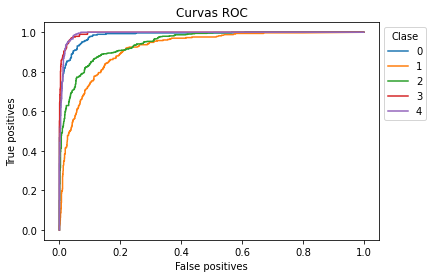

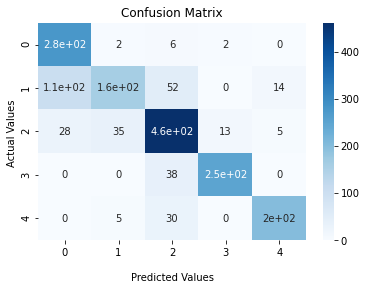

<ipython-input-13-d7ce65324f2e>:33: RuntimeWarning: divide by zero encountered in double_scalars
  a = (score[i,0]-score[i,1])/(score[i,1]+score[i,2])
<ipython-input-13-d7ce65324f2e>:33: RuntimeWarning: invalid value encountered in double_scalars
  a = (score[i,0]-score[i,1])/(score[i,1]+score[i,2])


Cohen-kappa 0.7832242140780716
0.8011834319526627


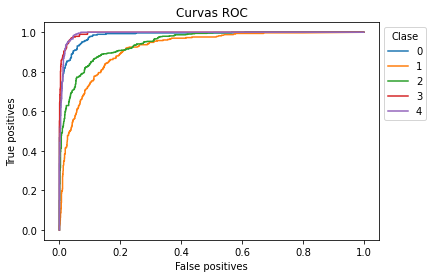

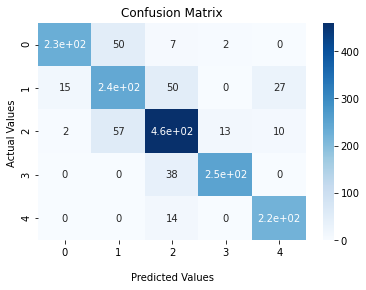

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       247
           1       0.72      0.69      0.71       348
           2       0.85      0.81      0.83       569
           3       0.87      0.94      0.90       267
           4       0.94      0.86      0.90       259

    accuracy                           0.83      1690
   macro avg       0.84      0.85      0.84      1690
weighted avg       0.83      0.83      0.83      1690



In [13]:
## RandomForest (ensembles) ## Tamaño reducido de variables 

criterion = 'entropy'
max_depth = None



# Train RF ensemble
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth=max_depth))
rf.fit(Xtr_reduced, ytr)
yb = rf.predict(Xts_reduced)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts_reduced, yts))

score = rf.predict_proba(Xts_reduced)
Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)

print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts_reduced, yts))

score1 = rf.predict(Xts_reduced)
sp.draw_ROC(yts,score,tag_list) 

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)

for i in range(len(yb)):
    a = (score[i,0]-score[i,1])/(score[i,1]+score[i,2])
    b = (score[i,0]-score[i,2])
    if yb[i] == 1:
        if score[i,4] >= 0.21:
            yb[i] = 4

    if yb[i] == 2:
        if score[i,4] >= 0.26:
            yb[i] = 4

    elif yb[i] == 0:
        if a <= 2.3:
            yb[i] = 1
        elif b <= 0.5:
            yb[i] = 2

Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)


tag_list = np.arange(0,5)

print('Cohen-kappa',cohen_kappa_score(yts, yb))
print(rf.score(Xts_reduced, yts))

score1 = rf.predict(Xts_reduced)
sp.draw_ROC(yts,score,tag_list) 

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)
print(classification_report(yb, yts))

<AxesSubplot:xlabel='p4', ylabel='Count'>

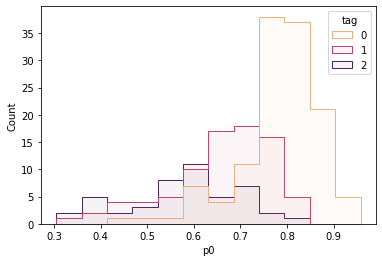

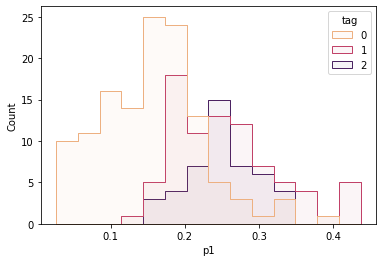

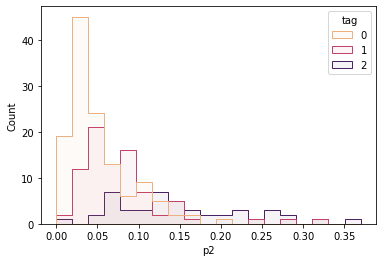

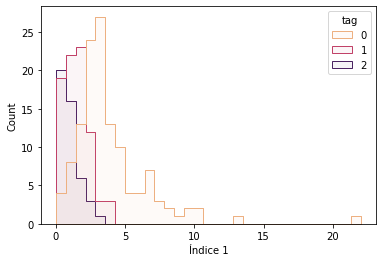

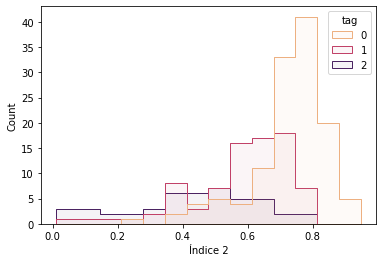

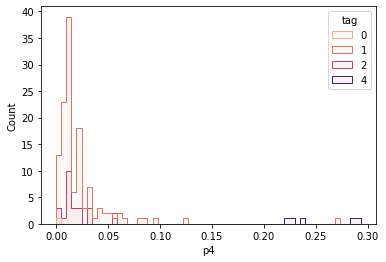

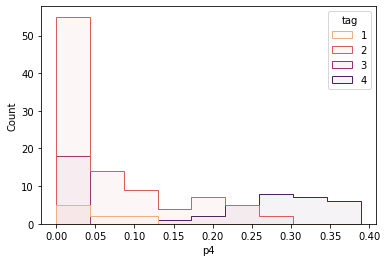

In [44]:
df = pd.DataFrame(score)
df.columns = ["p0","p1","p2","p3","p4"]
df["tag"] = yts
df["pred"] = yb
df["umbral1"] = (df.p0-df.p1)/(df.p1+df.p2)
df["umbral2"] = (df.p0-df.p2)


sns.histplot(df.iloc[np.where([i == 0 for i in df.pred])], x = "p0", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)
plt.figure()
sns.histplot(df.iloc[np.where([i == 0 for i in df.pred])], x = "p1", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)
plt.figure()
sns.histplot(df.iloc[np.where([i == 0 for i in df.pred])], x = "p2", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)



plt.figure()
sns.histplot(df.iloc[np.where([i == 0 for i in df.pred])], x = "umbral1", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)
plt.xlabel("Índice 1")

plt.figure()
sns.histplot(df.iloc[np.where([i == 0 for i in df.pred])], x = "umbral2", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)
plt.xlabel("Índice 2")

plt.figure()
sns.histplot(df.iloc[np.where([i == 1 for i in df.pred])], x = "p4", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)

plt.figure()
sns.histplot(df.iloc[np.where([i == 2 for i in df.pred])], x = "p4", hue = "tag",
            fill = True, alpha = 0.05, palette = "flare", element="step", common_norm=False)